# CNNで学習する

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
#import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, Dropout
from sklearn.model_selection import train_test_split
import keras.backend as K

In [2]:
images = [] # 画像データの配列
labels = [] # すべての正解ラベルの配列
class_name = ['healthy','disease'] # すべてのクラス名

# 1. 画像データのパスを読み込む

In [3]:
# 画像データのパスを読み込む
data_healthy = glob.glob("data/mer_spectrogram_images/healthy/*") # 健常者のデータ
data_bad     = glob.glob("data/mer_spectrogram_images/disease/*") # 疾患のある人のデータ

# 2. データセットを作る

In [4]:
# データセットを作る
for i in range(len(data_healthy)): # 健常者のデータ
  X = np.array((Image.open(data_healthy[i])).resize((224,224))) # 画像データをopenしてリサイズしてnumpy配列にする
  images.append(X) # 画像データを追加
  #labels.append([1,0]) # 正解ラベルを追加 One-Hotベクトル
  labels.append(0)

for i in range(len(data_bad)): # 疾患のある人のデータ
  X = np.array((Image.open(data_bad[i])).resize((224,224)))
  images.append(X) # 画像データを追加
  #labels.append([0,1]) # 正解ラベルを追加 One-Hotベクトル
  labels.append(1)

In [5]:
# numpy配列にする
images = np.array(images)
labels = np.array(labels)

In [6]:
# データの正規化
images = images.astype('float32') / 255.0 # 0~1に丸める

# 3. トレーニングデータとテストデータに分ける

In [7]:
# test_size - テストデータの割合を0~1の範囲で指定する 0.33で33%
# random_state - 乱数シードを指定してデータの振り分けを固定する
# データはシャッフルされる
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=111)

In [8]:
# One-hotベクトル化
train_labels_oh = keras.utils.to_categorical(train_labels, 2)
test_labels_oh = keras.utils.to_categorical(test_labels, 2)

# 4. CNNモデルを構築する

In [9]:
# CNNモデルを構築
#「Conv2D」を使って「畳み込みニューラルネットワーク」CNNを実装
model = Sequential()

# Conv2D(特徴マップ数, カーネルサイズ, ...)
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:])) # 畳み込み層 カーネルサイズ3x3, 特徴マップ32枚
model.add(Activation('relu')) # 活性化関数ReLUを使用する
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2)) # クラスは2個
model.add(Activation('softmax'))

## 4.1 コンパイルする

In [10]:
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2),
                  K.floatx())

def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())

# Precision (Macro)
def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())

def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) \
           / K.cast(class_count, K.floatx())

# Recall (Macro)
def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())

def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) \
           / K.cast(class_count, K.floatx())

In [11]:
model.compile(loss="categorical_crossentropy",
            optimizer="SGD",
            metrics=[
                "accuracy",
                #keras.metrics.Recall(),
                #keras.metrics.Precision()
                macro_precision,
                macro_recall
            ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      1

In [12]:
# 学習する 出力はなしで設定(verbose=0)
# epochs - 学習回数
history = model.fit(train_images, train_labels_oh, batch_size=5, epochs=50, validation_data=(test_images, test_labels_oh))

Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 0.7504 - accuracy: 0.4935 - macro_precision: 0.3448 - macro_recall: 0.5573 - val_loss: 0.6917 - val_accuracy: 0.4474 - val_macro_precision: 0.2208 - val_macro_recall: 0.5000
Epoch 2/50
16/16 [==============================] - 18s 1s/step - loss: 0.6869 - accuracy: 0.5455 - macro_precision: 0.4557 - macro_recall: 0.5755 - val_loss: 0.6756 - val_accuracy: 0.7632 - val_macro_precision: 0.7167 - val_macro_recall: 0.6979
Epoch 3/50
16/16 [==============================] - 18s 1s/step - loss: 0.6766 - accuracy: 0.6623 - macro_precision: 0.6099 - macro_recall: 0.6224 - val_loss: 0.6711 - val_accuracy: 0.7368 - val_macro_precision: 0.7427 - val_macro_recall: 0.7344
Epoch 4/50
16/16 [==============================] - 18s 1s/step - loss: 0.6624 - accuracy: 0.6234 - macro_precision: 0.5661 - macro_recall: 0.6146 - val_loss: 0.7009 - val_accuracy: 0.4474 - val_macro_precision: 0.2208 - val_macro_recall: 0.5000
Epoch 5/50
16/16

In [13]:
# 学習モデル保存
model.save("CNN.h5")

# 正解率を求める

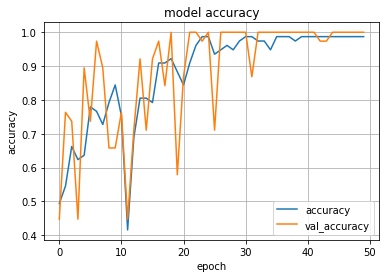

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.grid(True)
#plt.savefig("accuracy.jpg")
plt.show()

# 損失率を求める

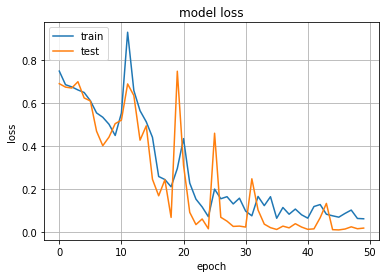

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
#plt.savefig("loss.jpg")
plt.show()

# 適合率を求める

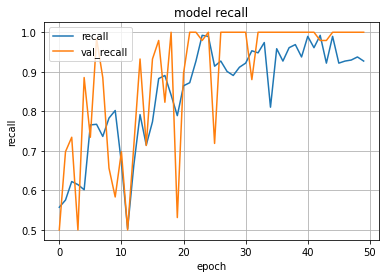

In [16]:
# 適合率の算出（予測したもののうち、実際のものと正しく予測できた割合）
plt.plot(history.history["macro_recall"])
plt.plot(history.history["val_macro_recall"])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['recall', 'val_recall'], loc='upper left')
plt.grid(True)
plt.show()

# 再現率を求める

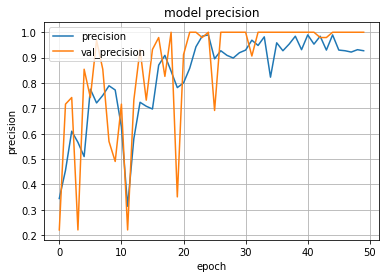

In [17]:
# 再現率の算出（実際のもののうち、正しく予測できた割合）
plt.plot(history.history["macro_precision"])
plt.plot(history.history["val_macro_precision"])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision'], loc='upper left')
plt.grid(True)
plt.show()

In [18]:
# 正解率の評価
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Test Accuracy:", test_acc)

ValueError: in user code:

    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1330 test_function  *
        return step_function(self, iterator)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1313 run_step  **
        outputs = model.test_step(data)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1269 test_step
        self.compiled_loss(
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\kante\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [ ]:
# 予測する
predictions = model.predict(test_images)
print(predictions[0]) # 1枚目のテストデータの予測

[2.2065286e-04 9.9977940e-01]


In [ ]:
from sklearn.metrics import recall_score, precision_score
#再現率
recall_score(test_labels, predictions)

In [ ]:
#適合率
precision_score(test_labels, predictions)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)